In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp
import scipy.stats as stats

In [2]:
data = pd.read_csv('medical_insurance.csv')

In [3]:
data.shape                   # data consists of 1338 entries 

(1338, 7)

In [4]:
data.head()                  # 3 categorical regressor variables

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
data.info()            # No missing values encountereed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


As observed, there might exist outliers in the BMI and CHARGES features 

In [7]:
data.duplicated().sum()

1

In [8]:
print(data.duplicated().sum())

1


In [9]:
data.corr()

C:\Users\bitha\AppData\Local\Temp\ipykernel_22076\2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [10]:
data.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


# Exploratory Data Analysis

## Univariate EDA 

In [11]:
feat_cat = data.select_dtypes(include = object).columns
feat_num = data.select_dtypes(exclude = object).columns
feat_cat, feat_num

(Index(['sex', 'smoker', 'region'], dtype='object'),
 Index(['age', 'bmi', 'children', 'charges'], dtype='object'))

In [12]:
num_data = data[feat_num]
cat_data = data[feat_cat]

<Axes: xlabel='sex', ylabel='count'>

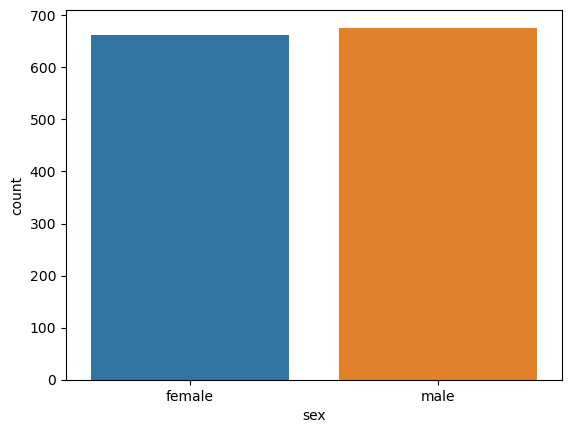

In [13]:
sns.countplot(x='sex', data=data)

There is almost equal representation among both males and females in the data.

<Axes: xlabel='smoker', ylabel='count'>

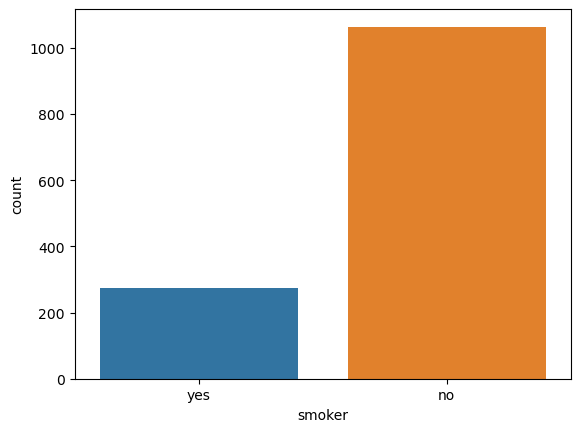

In [14]:
sns.countplot(x='smoker', data=data)

Only 20% of the people surveyed are smokers.

<Axes: xlabel='region', ylabel='count'>

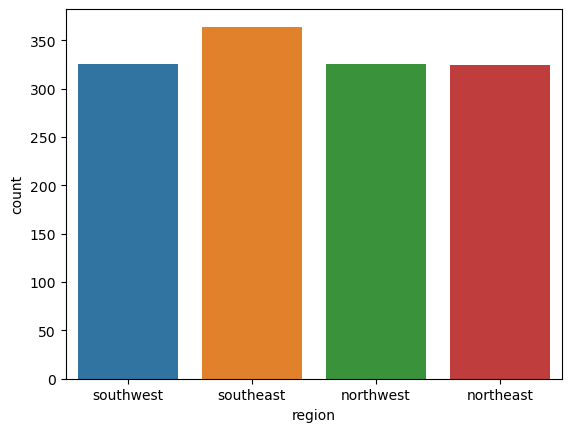

In [15]:
sns.countplot(x='region', data=data)

The people surveyed hail from all the regions almost uniformly

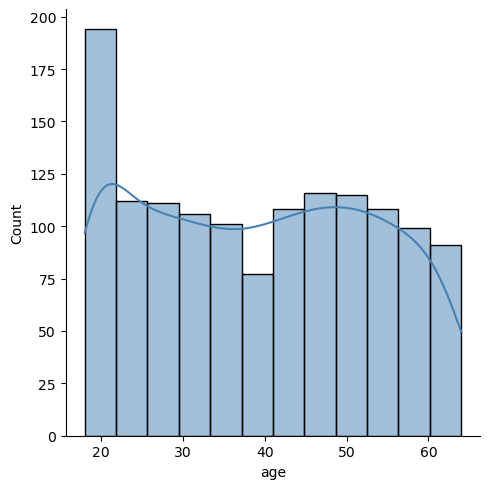

In [16]:
sns.displot(data['age'], color= ('steelblue'), kde=True)


There are comparitively many people around 20 years of age compared to other age groups.

<Axes: >

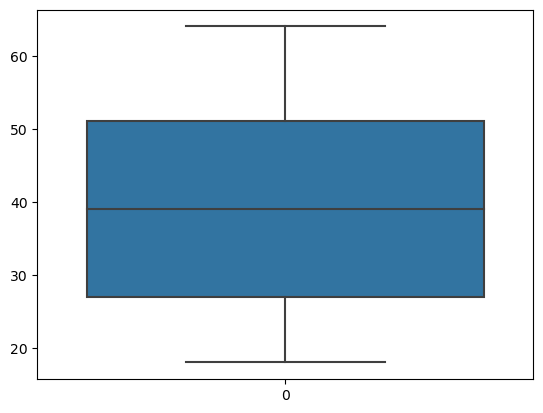

In [17]:
sns.boxplot(data['age'])

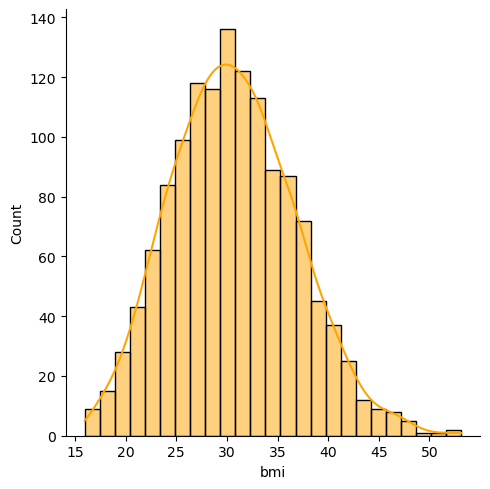

In [18]:
sns.displot(data['bmi'], color= ('orange'), kde=True) 
# sns.displot(data['bmi'], kind = 'kde', color= ('orange'))


<Axes: >

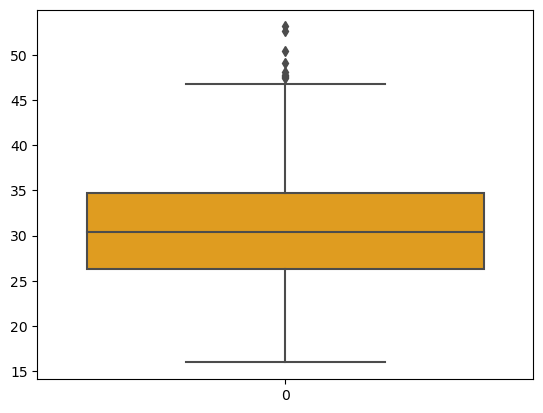

In [19]:
sns.boxplot(data['bmi'], color='orange')

The BMI of the surveyed individuals are approximately normally distributed. The BMI data had a few outliers that were capped to the upper bound.

      age     sex    bmi  children smoker     region      charges
116    58    male  49.06         0     no  southeast  11381.32540
286    46  female  48.07         2     no  northeast   9432.92530
401    47    male  47.52         1     no  southeast   8083.91980
543    54  female  47.41         0    yes  southeast  63770.42801
847    23    male  50.38         1     no  southeast   2438.05520
860    37  female  47.60         2    yes  southwest  46113.51100
1047   22    male  52.58         1    yes  southeast  44501.39820
1088   52    male  47.74         1     no  southeast   9748.91060
1317   18    male  53.13         0     no  southeast   1163.46270


<Axes: >

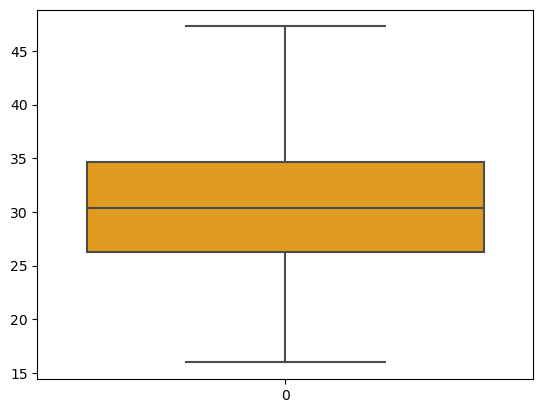

In [20]:
Q1 = data['bmi'].quantile(0.25)
Q3 = data['bmi'].quantile(0.75)
IQR = Q3-Q1

lb = Q1 - 1.5*IQR
ub = Q3 + 1.5*IQR

print(data[data['bmi']>ub])

data['bmi'] = data['bmi'].apply(lambda x : lb if x<lb else x)
data['bmi'] = data['bmi'].apply(lambda x : ub if x>ub else x)

sns.boxplot(data['bmi'], color='orange')

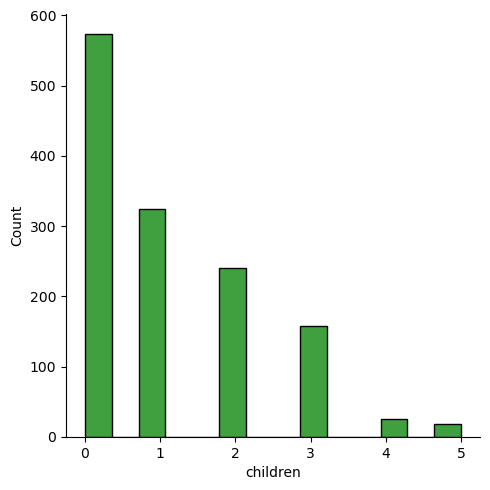

In [21]:
sns.displot(data['children'], color= ('green')) 
# sns.displot(data['children'], kind = 'kde', color= ('green')) 

There is a very high portion of individuals with no children and the number decreases with increase in number of children.

In [22]:
# sns.boxplot(data['children'], color='green')

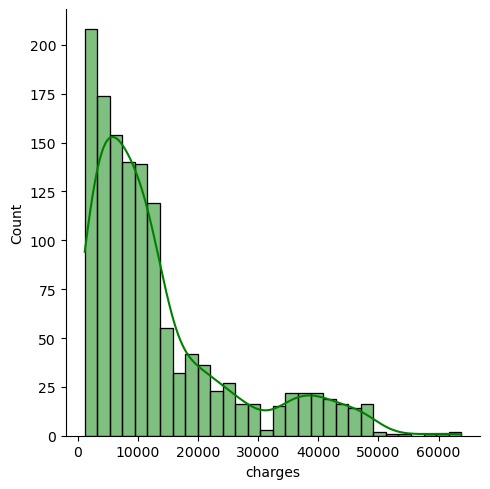

In [23]:
sns.displot(data['charges'], color= ('green'), kde=True) 
# sns.displot(data['charges'], kind = 'kde', color= ('green')) 

<Axes: >

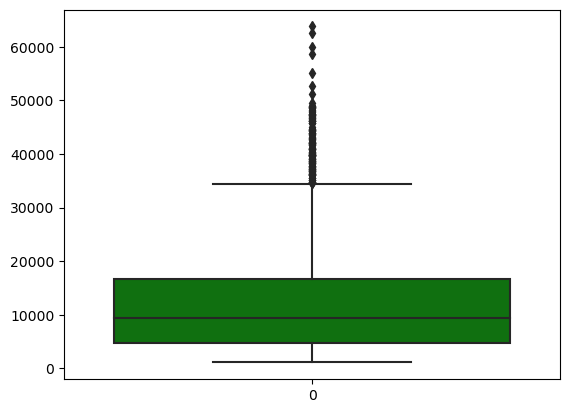

In [24]:
sns.boxplot(data['charges'], color='green')

The response (output) variable ie. 'charges' is right-skewed and not normally distributed as need to be to satisfy the assumptions of linear regression. To ormalize the response variable we need to apply some appropriate transformation

## Bivariate EDA 

<Axes: xlabel='sex', ylabel='charges'>

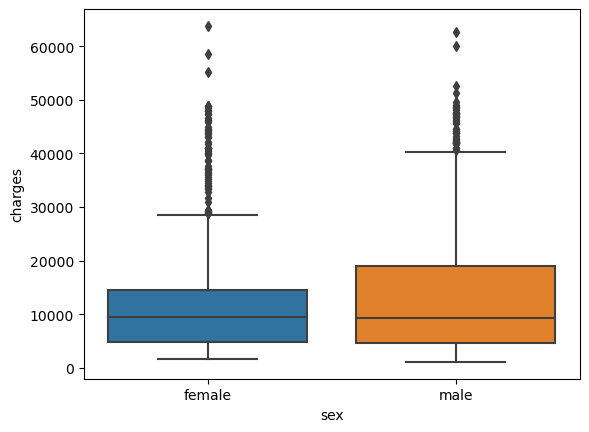

In [25]:
sns.boxplot(data, x='sex', y = 'charges')

<Axes: xlabel='smoker', ylabel='charges'>

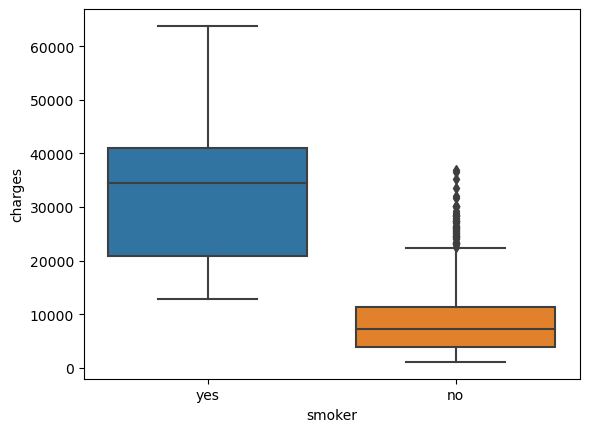

In [26]:
sns.boxplot(data, x='smoker', y = 'charges')

There exist some individuals who do not smoke but have comparitively higher insurance prices than majority of non-smokers.

<Axes: xlabel='region', ylabel='charges'>

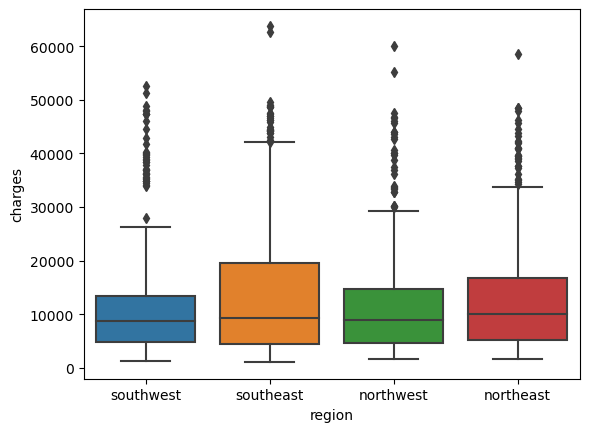

In [27]:
sns.boxplot(data, x='region', y='charges')

<Axes: xlabel='age', ylabel='charges'>

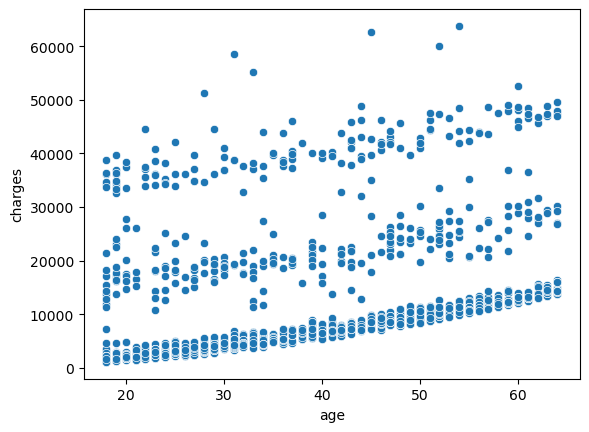

In [28]:
sns.scatterplot(data, x = 'age', y = 'charges') 

<Axes: xlabel='bmi', ylabel='charges'>

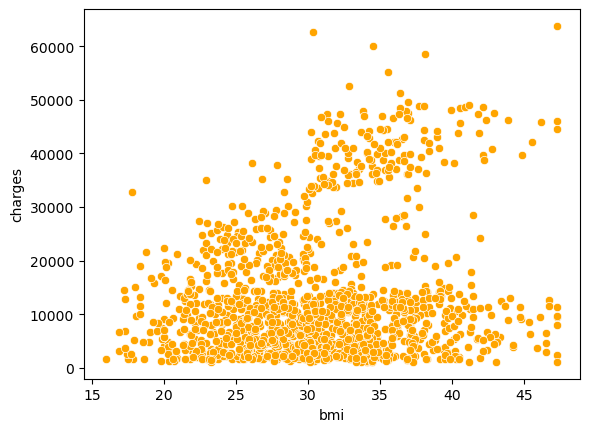

In [29]:
sns.scatterplot(data, x = 'bmi', y = 'charges', color='orange')

The people with high medical insurance costs have high BMI indicating obesity or an unhealthy lifestyle 

<Axes: xlabel='children', ylabel='charges'>

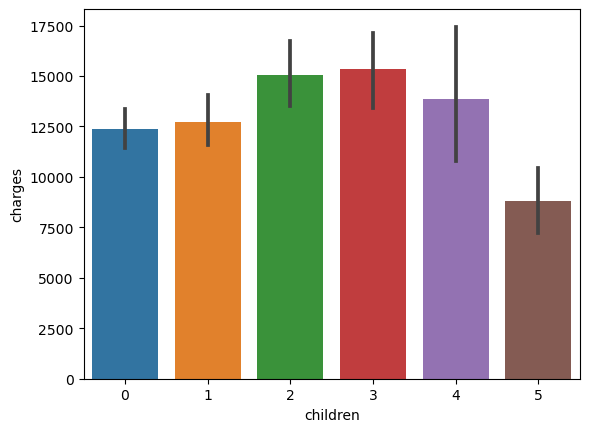

In [30]:
sns.barplot(data, x = 'children', y = 'charges')

Families with more than 2 children have pay higher prices of medical insurance. Surprisingly, families with 5 children pay lower insurance costs which can be due to financial instability and poor educational awareness. 

C:\Users\bitha\AppData\Local\Temp\ipykernel_22076\4069945627.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


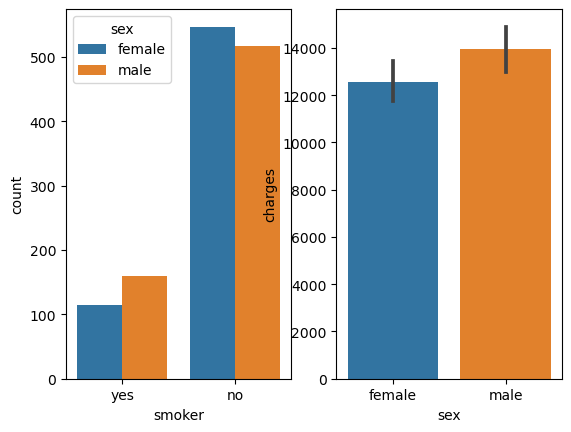

In [31]:
fig, ax = plt.subplots(1,2)

sns.countplot(data=data, x=data['smoker'], hue=data['sex'], ax=ax[0])
sns.barplot(data, x = 'sex', y = 'charges', ax = ax[1])
fig.show()

A higher proportion of the smokers are males and it can be observed that males pay higher prices of medical insurance 

<Axes: xlabel='children', ylabel='count'>

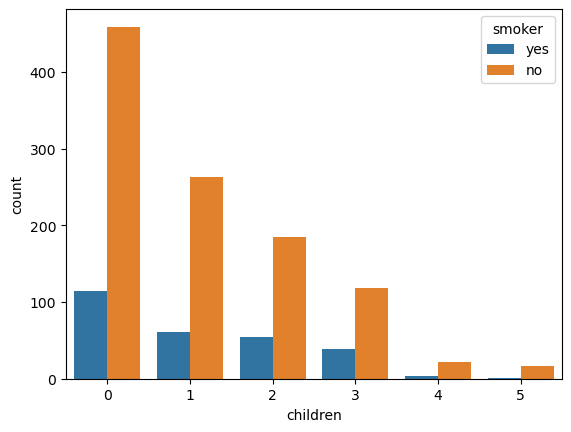

In [32]:
sns.countplot(data=data, x=data['children'], hue=data['smoker'])

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64 



<Axes: >

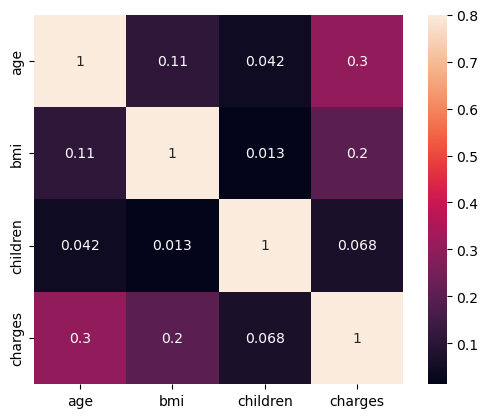

In [33]:
correlation = num_data.corr() 
print(correlation['charges'].sort_values(ascending=False),'\n')
sns.heatmap(correlation, square=True, vmax=0.8, annot=True)

There doesnt exist high correlation (> 0.9) between any of the numerical features. 

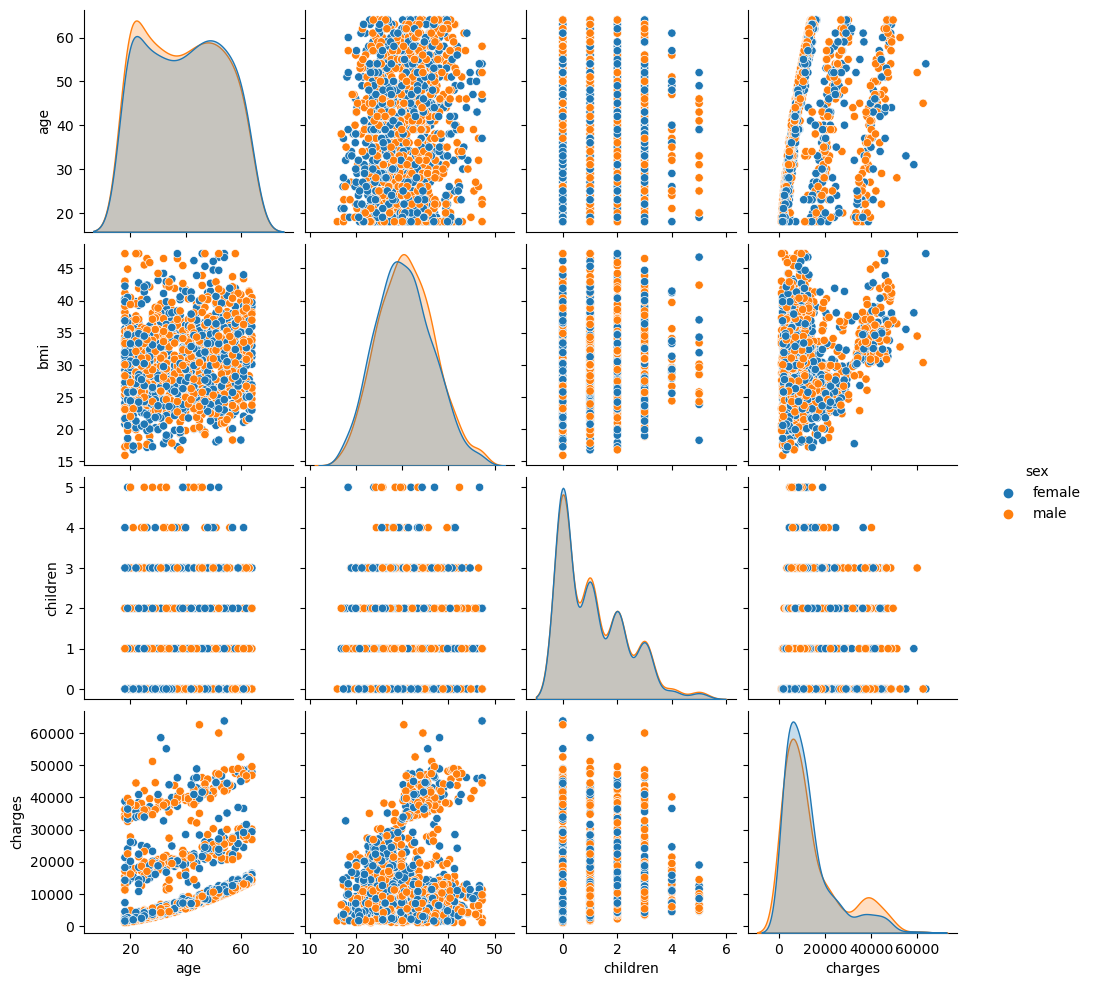

In [34]:
sns.pairplot(data, hue="sex")

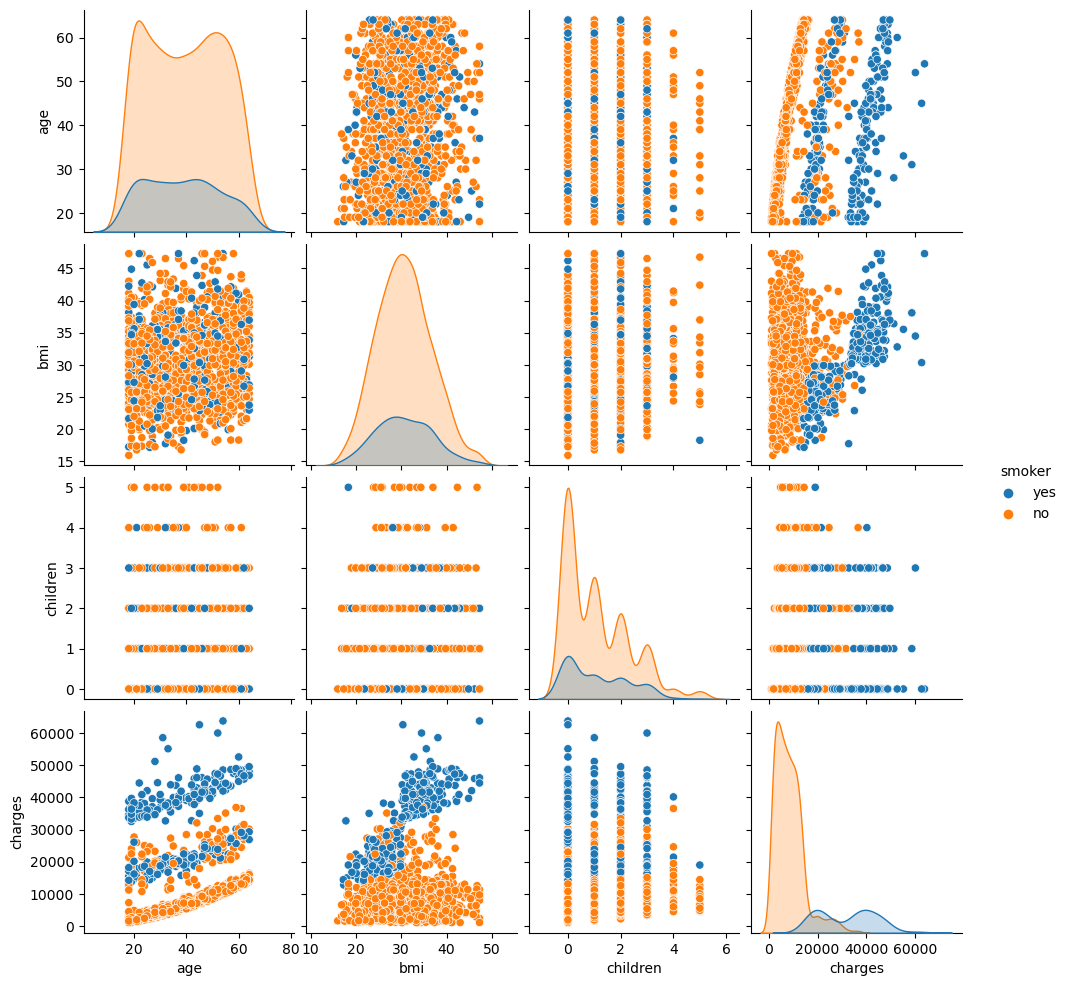

In [35]:
sns.pairplot(data, hue="smoker")

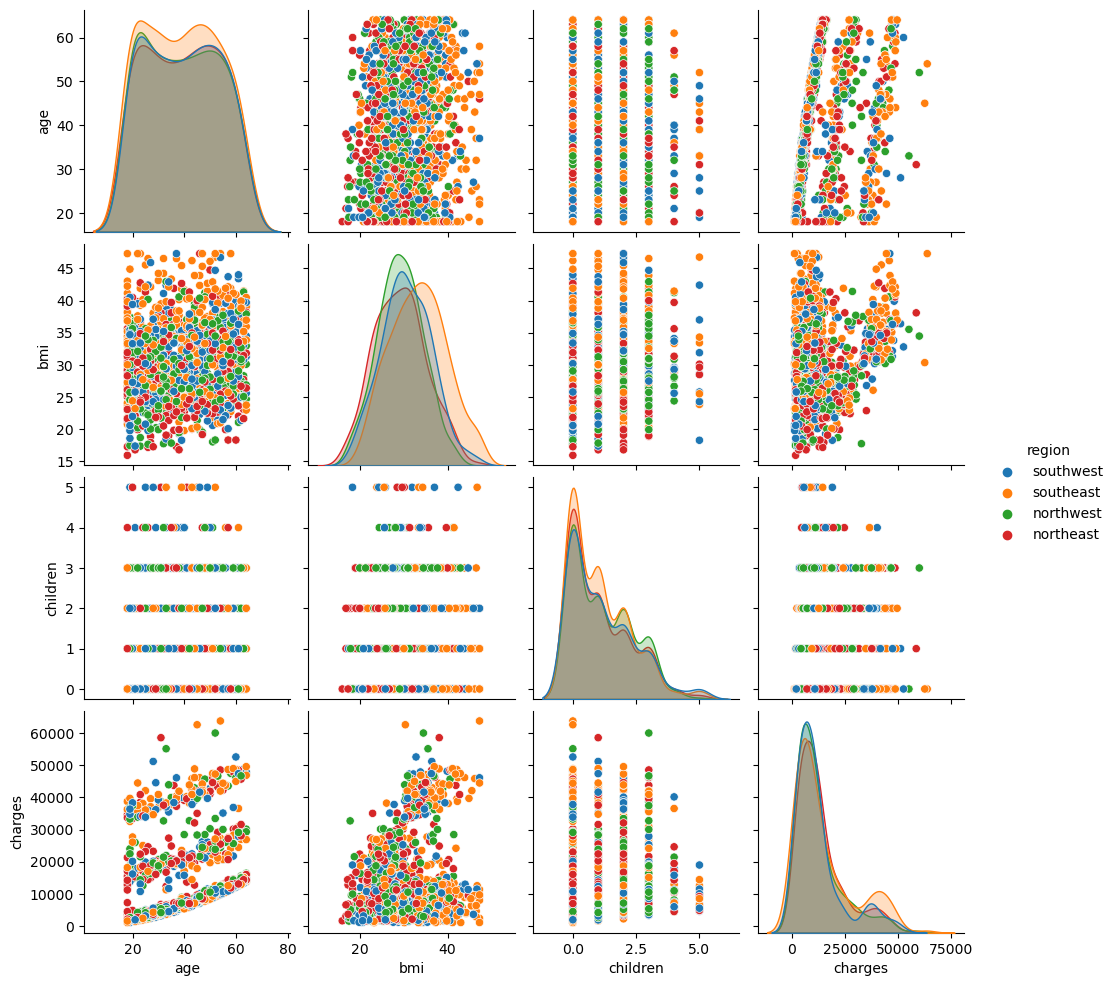

In [36]:
sns.pairplot(data, hue="region")

# One Hot Encoding

In [37]:
ohe_data = data

In [38]:
ohe_data['sex'] = ohe_data['sex'].astype('category')
ohe_data['smoker'] = ohe_data['smoker'].astype('category')
ohe_data['region'] = ohe_data['region'].astype('category')

In [39]:
ohe_data['sex_new'] = ohe_data['sex'].cat.codes
ohe_data['smoker_new'] = ohe_data['smoker'].cat.codes
ohe_data['region_new'] = ohe_data['region'].cat.codes

In [40]:
enc = OneHotEncoder(drop = 'first', dtype= 'int32')

enc_data = pd.DataFrame(enc.fit_transform(ohe_data[['sex_new', 'smoker_new', 'region_new']]).toarray())

new_data = ohe_data.join(enc_data)
print(new_data)

      age     sex     bmi  children smoker     region      charges  sex_new  \
0      19  female  27.900         0    yes  southwest  16884.92400        0   
1      18    male  33.770         1     no  southeast   1725.55230        1   
2      28    male  33.000         3     no  southeast   4449.46200        1   
3      33    male  22.705         0     no  northwest  21984.47061        1   
4      32    male  28.880         0     no  northwest   3866.85520        1   
...   ...     ...     ...       ...    ...        ...          ...      ...   
1333   50    male  30.970         3     no  northwest  10600.54830        1   
1334   18  female  31.920         0     no  northeast   2205.98080        0   
1335   18  female  36.850         0     no  southeast   1629.83350        0   
1336   21  female  25.800         0     no  southwest   2007.94500        0   
1337   61  female  29.070         0    yes  northwest  29141.36030        0   

      smoker_new  region_new  0  1  2  3  4  
0    

In [41]:
new_data = new_data.drop(['sex_new', 'smoker_new', 'region_new'], axis=1)

In [42]:
new_data.head()

,age,sex,bmi,children,smoker,region,charges,0,1,2,3,4
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1,0,0


In [43]:
new_data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 0, 1, 2,
       3, 4],
      dtype='object')

In [44]:
new_data.columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'male', 'smokes', 'northwest',
       'southeast', 'southwest']

new_data.head()

,age,sex,bmi,children,smoker,region,charges,male,smokes,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1,0,0


In [45]:
df = new_data

In [46]:
df.head()

,age,sex,bmi,children,smoker,region,charges,male,smokes,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1,0,0


In [47]:
df = df.drop(['sex', 'smoker', 'region'], axis=1)

In [48]:
df.head()

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [49]:
data.head()

,age,sex,bmi,children,smoker,region,charges,sex_new,smoker_new,region_new
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,3
1,18,male,33.770,1,no,southeast,1725.55230,1,0,2
2,28,male,33.000,3,no,southeast,4449.46200,1,0,2
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1


In [50]:
data = data.drop(['sex_new','smoker_new','region_new'], axis=1)

In [51]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [52]:
data.shape

(1338, 7)

In [53]:
df.shape

(1338, 9)

In [54]:
# df = df.dropna()

In [55]:
df_to_transform = df['charges']
df_transformed, lambda_ = stats.boxcox(df_to_transform) 
df['charges'] = df_transformed
print("Lambda value = ", lambda_)

Lambda value =  0.043649053770664956


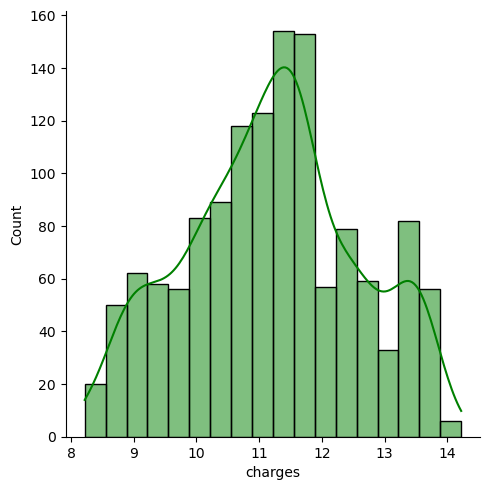

In [56]:
sns.displot(df['charges'], color= ('green'), kde=True)

# OLS Model Summary

In [57]:
X = df.drop(columns = 'charges', axis=1)
Y = df['charges']

In [58]:
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

In [59]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     559.3
Date:                Fri, 20 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:43:20   Log-Likelihood:                -1329.8
No. Observations:                1338   AIC:                             2678.
Df Residuals:                    1329   BIC:                             2724.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1207      0.107     75.709      0.000       7.910       8.331
age            0.0505      0.001     39.198      0.000       0.048       0.053
bmi            0.0210      0.003      6.726      0.000       0.015       0.027
children       0.1459      0.015      9.782      0.000       0.117       0.175
male          -0.1062      0.036     -2.949      0.003      -0.177      -0.036
smokes         2.3432      0.045     52.414      0.000       2.255       2.431
northwest     -0.0928      0.052     -1.802      0.072      -0.194       0.008
southeast     -0.2280      0.052     -4.402      0.000      -0.330      -0.126
southwest     -0.1884      0.052     -3.644      0.000      -0.290      -0.087
==============================================================================
Omnibus:                      482.068   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1772.075
Skew:                           1.744   Prob(JB):                         0.00
Kurtosis:                       7.429   Cond. No.                         312.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

p-value of the variable 'male' = 0.70 > 0.05 implying it doesnt have a significant impact on the response variable

# Influential Points by Cook's Distance

In [60]:
influence = model.get_influence()
cooks = influence.cooks_distance
print(cooks)

(array([2.35997968e-04, 7.84571721e-04, 5.40593779e-05, ...,
       1.21248307e-03, 4.23743798e-04, 3.05600166e-03]), array([1., 1., 1., ..., 1., 1., 1.]))


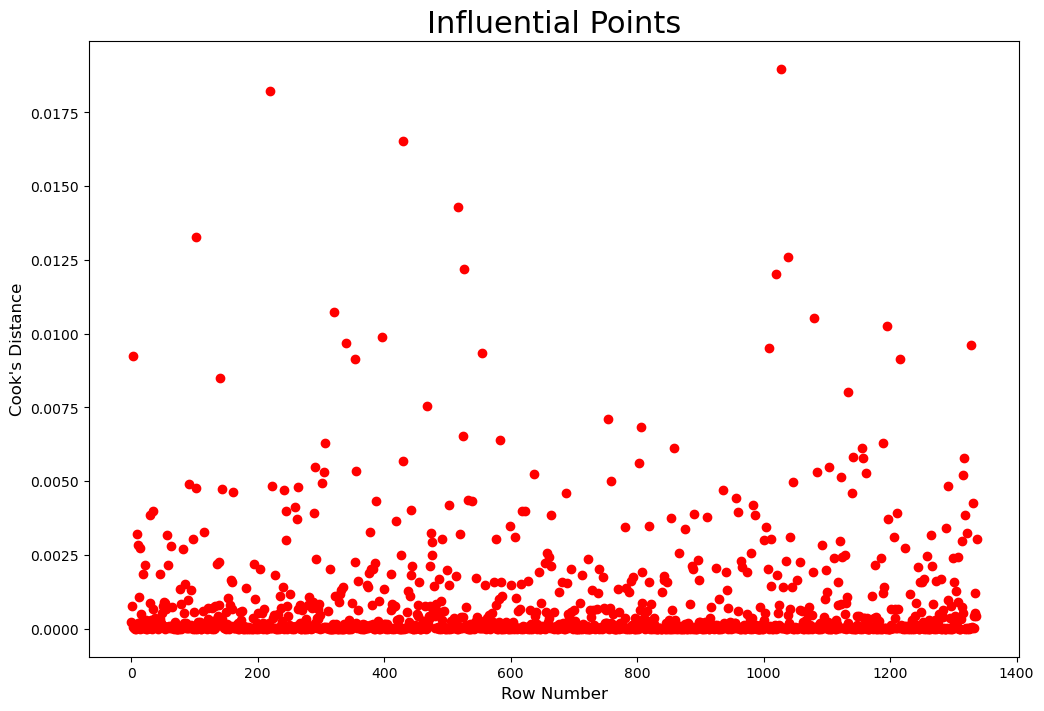

In [61]:
plt.figure(figsize = (12,8))
plt.scatter(df.index, cooks[0], color='red')
plt.xlabel('Row Number', fontsize=12)
plt.ylabel("Cook's Distance", fontsize=12)
plt.title("Influential Points", fontsize=22)
plt.show()


In [62]:
mean_cooks = np.mean(cooks[0])
mean_cooks

0.000777055610688671

In [63]:
influential_points = df.index[cooks[0] > (4/1338)]
influential_points

Int64Index([   3,    9,   30,   34,   57,   92,   98,  102,  103,  115,
            ...
            1265, 1288, 1291, 1315, 1317, 1318, 1321, 1328, 1331, 1337],
           dtype='int64', length=108)

In [64]:
df.iloc[influential_points, :]

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
3,33,22.705,0,12.534950,1,0,1,0,0
9,60,25.840,0,12.961890,0,0,1,0,0
30,22,35.600,0,13.287945,1,1,0,0,1
34,28,36.400,1,13.867168,1,1,0,0,1
57,18,31.680,2,13.230001,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...
1318,35,39.710,4,12.349640,1,0,0,0,0
1321,62,26.695,0,12.916785,1,1,0,0,0
1328,23,24.225,2,12.563638,0,0,0,0,0
1331,23,33.400,0,11.451579,0,0,0,0,1


In [65]:
df = df.drop(influential_points)
df.head()


,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
0,19,27.90,0,12.128980,0,1,0,0,1
1,18,33.77,1,8.808596,1,0,0,1,0
2,28,33.00,3,10.147521,1,0,0,1,0
4,32,28.88,0,9.945637,1,0,1,0,0
5,31,25.74,0,9.904186,0,0,0,1,0


In [66]:
df.shape

(1230, 9)

### Assumption 4 - Homoscedasticity 

In [67]:
# BP test for testing for homoscedasticity

X = df.drop(columns = 'charges', axis=1)
Y = df['charges']

X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()
model.summary()

_, bp_value, _, _ = sm.stats.diagnostic.het_breuschpagan(model.resid, X)
print(bp_value)

1.2990084709720797e-37


Since p value < 0.05, Ho is rejected, indicating evidence of heteroscedaticity (ie. the variance of the residuals is not constant)

# Fitting MLR model

In [68]:
X = df.drop(columns = 'charges', axis=1)
Y = df['charges']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [69]:
lr = LinearRegression()
model = lr.fit(X_train, Y_train)

In [70]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [71]:
residual = Y_train - Y_train_pred
print(model.coef_)

[ 0.05852731  0.01713138  0.15185027 -0.11604766  2.42635364 -0.13978429
 -0.23373439 -0.16997691]


In [72]:
print(model.intercept_)

7.790269974300157


In [73]:
print("Training R^2 = ",r2_score(Y_train, Y_train_pred))
print("Testing R^2 = ",r2_score(Y_test, Y_test_pred))

Training R^2 =  0.9107026240763232
Testing R^2 =  0.9316413661109747


### Assumption 2 -  Checking for multicollinearity

In [74]:
# VARIANCE INFLATION FACTOR
p = X_train.shape[1]
print(p)

vif = [variance_inflation_factor(X_train.values, i) for i in range(p)]
vif = pd.Series(vif, index = X_train.columns)
print(vif)

8
age           8.234441
bmi          11.935773
children      1.815031
male          1.964704
smokes        1.242086
northwest     1.847667
southeast     2.240399
southwest     2.025652
dtype: float64


VIF of 'age' feature is greater than 5 indicating possible existence of multicollinearity.
VIF of 'bmi' feature is greater that 10 indicating presence of significant multicollinearity that needs to be corrected.

charges     1.000000
age         0.612445
children    0.183208
bmi         0.156010
Name: charges, dtype: float64 



<Axes: >

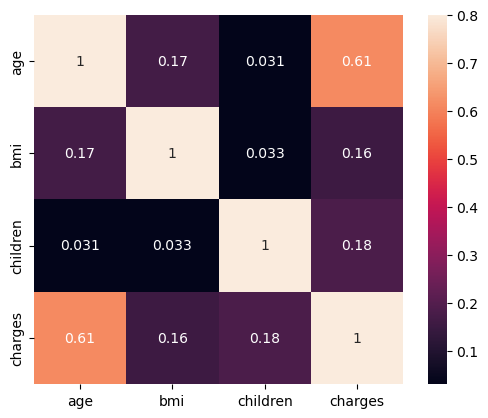

In [75]:
# CORRELATION HEATMAP
num_data = df[feat_num]
correlation = num_data.corr()
print(correlation['charges'].sort_values(ascending=False),'\n')
sns.heatmap(correlation, square=True, vmax=0.8, annot=True)

### Assumption 3 - Normality of residuals

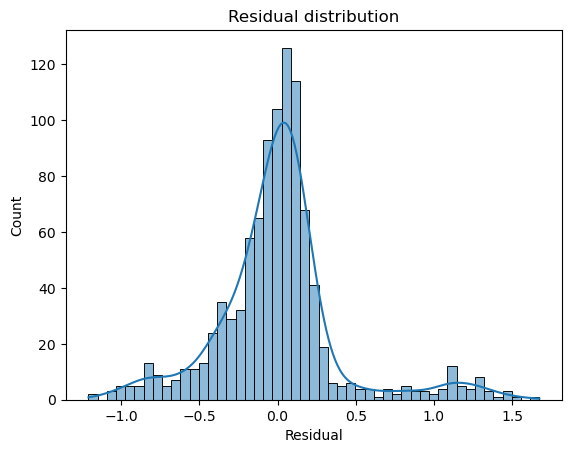

In [76]:
sns.histplot(residual, kde=True)
plt.xlabel("Residual")
plt.title("Residual distribution")
plt.show()

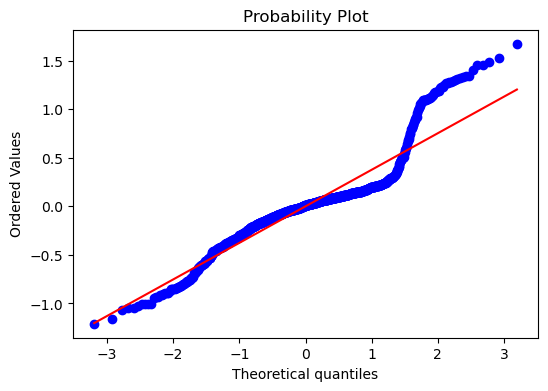

In [77]:
# QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual, plot=ax, fit=True)
plt.show()

In [78]:
# Shapiro-Wilk test for normality of residuals
statistic, p_value = sp.stats.shapiro(residual)
print(statistic, p_value)

0.8887063264846802 5.087285399828574e-26


Since p value < 0.05, Ho is rejected, indicating residuals are not normally distributed

### Assumption 5 - Autocorrelation 

In [79]:
# Durbin Watson test for auto-correlation
durbin_watson_statistic = sm.stats.durbin_watson(residual)
print(durbin_watson_statistic)

1.9467117550679611


Since the Durbin-Watson statistic value is around 2, it indicates that there is no significant autocorrelation in the residuals.


In [80]:
# sns.residplot(x=(, y=residual)
# plt.xlabel("Y_train_pred", fontsize = 12)
# plt.ylabel("residual", fontsize = 12)
# plt.title("Predicted values vs. Residual", fontsize=15)
# plt.show()


## Residual Plots 

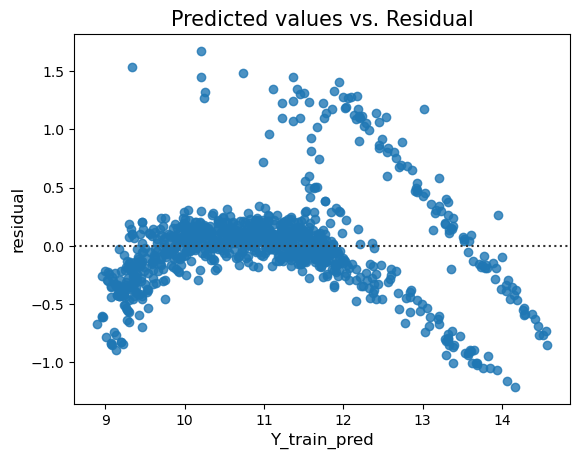

In [81]:
sns.residplot(x=Y_train_pred, y=residual)
plt.xlabel("Y_train_pred", fontsize = 12)
plt.ylabel("residual", fontsize = 12)
plt.title("Predicted values vs. Residual", fontsize=15)
plt.show()


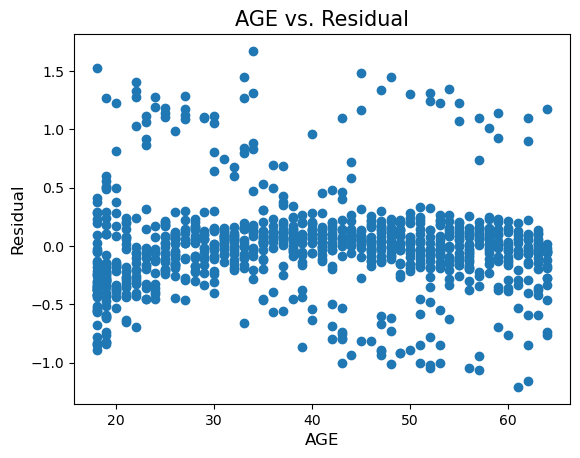

In [82]:
plt.scatter(X_train['age'], residual)
plt.xlabel("AGE", fontsize = 12)
plt.ylabel("Residual", fontsize = 12)
plt.title("AGE vs. Residual", fontsize=15)
plt.show()


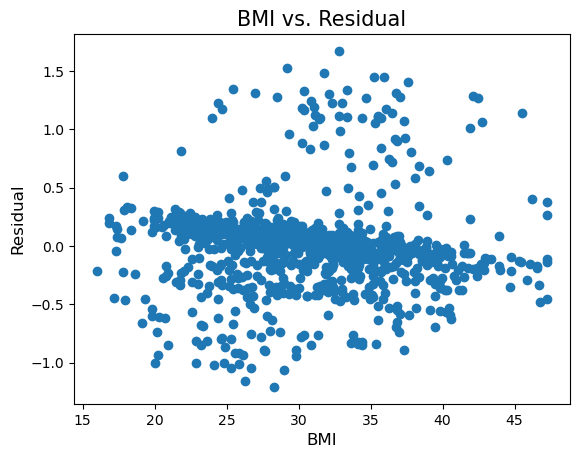

In [83]:
plt.scatter(X_train['bmi'], residual)
plt.xlabel("BMI", fontsize = 12)
plt.ylabel("Residual", fontsize = 12)
plt.title("BMI vs. Residual", fontsize=15)
plt.show()

In the BMI vs. Residual plot, the data points are observed to be forming clusters. S we check the BMI vs charges plot to get better understanding. 

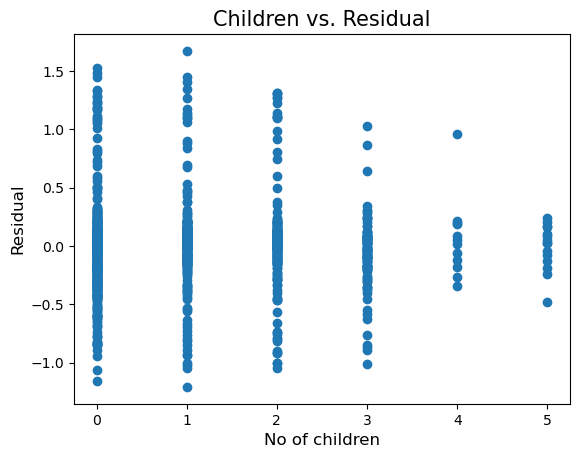

In [84]:
plt.scatter(X_train['children'], residual)
plt.xlabel("No of children", fontsize = 12)
plt.ylabel("Residual", fontsize = 12)
plt.title("Children vs. Residual", fontsize=15)
plt.show()


In [85]:
df.head()

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
0,19,27.90,0,12.128980,0,1,0,0,1
1,18,33.77,1,8.808596,1,0,0,1,0
2,28,33.00,3,10.147521,1,0,0,1,0
4,32,28.88,0,9.945637,1,0,1,0,0
5,31,25.74,0,9.904186,0,0,0,1,0


In [86]:
SPL = df[df['smokes']==1]              # smoking 
NSPL = df[df['smokes']==0]             # non smokers


<Axes: xlabel='bmi', ylabel='charges'>

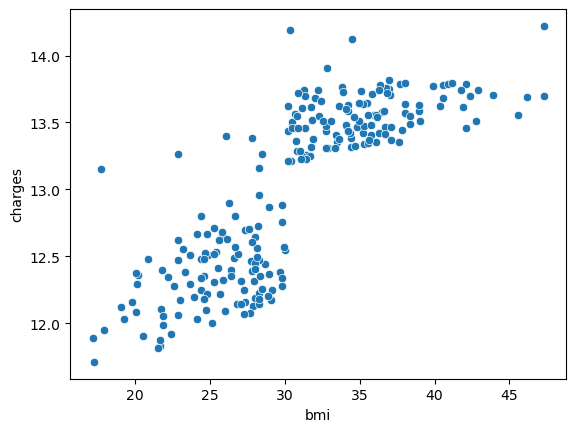

In [87]:
sns.scatterplot(SPL, x = 'bmi', y = 'charges')

<Axes: xlabel='bmi', ylabel='charges'>

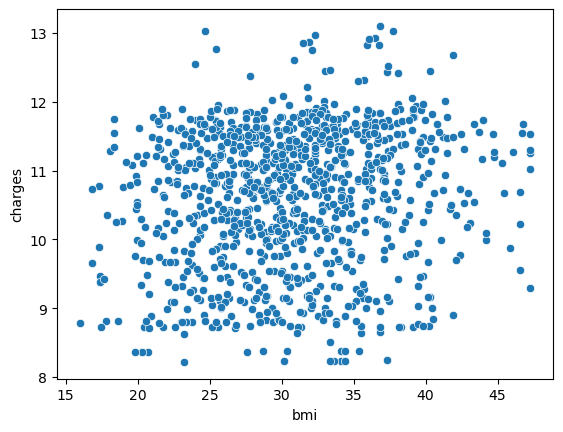

In [88]:
sns.scatterplot(NSPL, x = 'bmi', y = 'charges')

As seen from the above two scatter plots of BMI (grouped into smoker and non-smoker) vs charges, we observed that there are 2 clusters (BMI<30, BMI>30) being formed in the smoker group of people. And non smokers are distributed evenly(randomly) in the BMI vs charges scatter plot. Therefore we split our data into 3 sections namely:
1. Smoker with BMI<=30
2. Smoker with BMI>30
3. Non Smoker

# Splitting the data into 3 sections

In [89]:
df_1 = SPL[SPL['bmi']<=30]                               
df_1.head()

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
0,19,27.90,0,12.128980,0,1,0,0,1
11,62,26.29,0,12.900420,0,1,0,1,0
52,48,28.00,1,12.642741,1,1,0,0,1
58,53,22.88,1,12.621300,0,1,0,1,0
64,20,22.42,0,11.918896,0,1,1,0,0


In [90]:
df_2 = SPL[SPL['bmi']>30]                            # smokers with high bMI
df_2.head()

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
14,27,42.13,0,13.457696,1,1,0,1,0
19,30,35.30,0,13.342616,1,1,0,0,1
23,34,31.92,1,13.379337,0,1,0,0,0
29,31,36.30,2,13.421200,1,1,0,0,1
38,35,36.67,1,13.464196,1,1,0,0,0


In [91]:
df_3 = df[df['smokes']==0]                     # non smokers.
df_3.head()

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
1,18,33.77,1,8.808596,1,0,0,1,0
2,28,33.00,3,10.147521,1,0,0,1,0
4,32,28.88,0,9.945637,1,0,1,0,0
5,31,25.74,0,9.904186,0,0,0,1,0
6,46,33.44,1,11.048851,0,0,0,1,0


In [92]:
print(df_1.shape, df_2.shape, df_3.shape)

(114, 9) (120, 9) (996, 9)


# Model 1 : Smoker with BMI <= 30

In [93]:
X_1 = df_1.drop(columns = 'charges', axis=1)
Y_1 = df_1['charges']

X_1 = sm.add_constant(X_1)

model_1 = sm.OLS(Y_1, X_1).fit()

### Feature Selection by Backward Elimination

In [94]:
while True:
    max_pvalue = model_1.pvalues.max()
    
    if max_pvalue > 0.05:
        feature_to_remove = model_1.pvalues.idxmax()
        X_1 = X_1.drop(columns=[feature_to_remove])
        model_1 = sm.OLS(Y_1, X_1).fit()
        
    else:
        break   

In [95]:
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     66.72
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           9.38e-20
Time:                        16:43:25   Log-Likelihood:                 10.317
No. Observations:                 114   AIC:                            -14.63
Df Residuals:                     111   BIC:                            -6.426
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0184      0.002     10.203      0.0

p-value for 'male' variable has become less than 0.05

In [96]:
X_1.head()

,age,bmi,smokes
0,19,27.90,1
11,62,26.29,1
52,48,28.00,1
58,53,22.88,1
64,20,22.42,1


### BP test for homoscedasticity 

In [97]:
_, bp_value, _, _ = sm.stats.diagnostic.het_breuschpagan(model_1.resid, X_1)
print(bp_value)

0.5580141737294924


Since p value > 0.05, Ho is rejected, indicating evidence of homoscedaticity (ie. the variance of the residuals is constant)

## Fitting MLR on model 1


#### Box Cox transformation 

In [98]:
# df1_to_transform = Y_1
# df1_transformed, lambda_1 = stats.boxcox(df1_to_transform) 
# Y_1 = df1_transformed

In [99]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_1, Y_1, test_size=0.2, random_state=5)

In [100]:
lr = LinearRegression()
lrmodel_1 = lr.fit(X1_train, Y1_train)

In [101]:
Y1_train_pred = lrmodel_1.predict(X1_train)
Y1_test_pred = lrmodel_1.predict(X1_test)


In [102]:
residual_1 = Y1_train - Y1_train_pred

In [103]:
print(lrmodel_1.coef_)

[0.01724306 0.03288837 0.        ]


In [104]:
print(lrmodel_1.intercept_)

10.957590986387016


In [105]:
r2 = r2_score(Y1_train, Y1_train_pred)
adjr2 = 1-((1-r2)*108/106)

In [106]:
print("Training R^2 = ",r2)
print("Adjusted R^2 = ", adjr2)

Training R^2 =  0.5130491228058777
Adjusted R^2 =  0.5038613704059886


## Ridge regression model 

In [107]:
ridge_1 = Ridge()
ridge_1.fit(X1_train, Y1_train)
ridge_Y1_train_pred = ridge_1.predict(X1_train)
#ridge_r1_train = metrics.r2_score(Y_train, ridge_training_data_prediction)
print('ridge R^2 (train data) :', r2_score(Y1_train, ridge_Y1_train_pred))

ridge_Y1_test_pred = ridge_1.predict(X1_test)
#ridge_r1_test = metrics.r2_score(Y_test, ridge_testing_data_prediction)
print('ridge R^2 (test data) :', r2_score(Y1_test, ridge_Y1_test_pred))

ridge R^2 (train data) : 0.5130489635362705
ridge R^2 (test data) : 0.6018600651775502


### VIF test for multicollinearity 

In [108]:
# VIF test for multicollinearity
p = X1_train.shape[1]
print(p)

vif = [variance_inflation_factor(X1_train.values, i) for i in range(p)]
vif = pd.Series(vif, index = X1_train.columns)
print(vif)

3
age        1.000485
bmi        1.000485
smokes    82.082705
dtype: float64


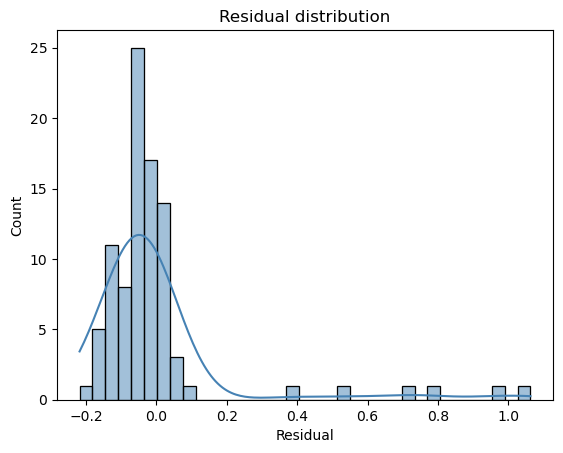

In [109]:
# Checking normality of residuals

sns.histplot(residual_1, kde=True, color="steelblue")
plt.xlabel("Residual")
plt.title("Residual distribution")
plt.show()

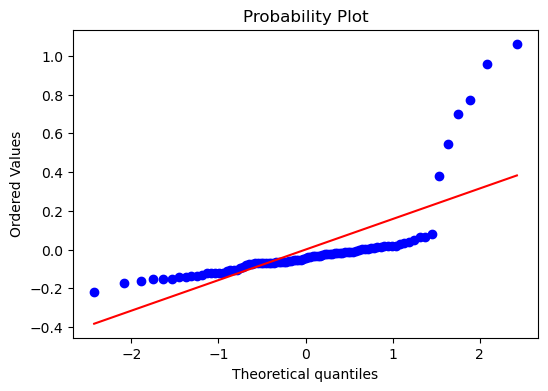

In [110]:
# QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual_1, plot=ax, fit=True)
plt.show()

In [111]:
# Shapiro-Wilk test for normality of residuals
statistic_1, p_value_1 = sp.stats.shapiro(residual_1)
print(statistic_1, p_value_1)

0.537010669708252 1.805805210360967e-15


In [112]:
# Durbin Watson test for auto-correlation
durbin_watson_statistic = sm.stats.durbin_watson(residual_1)
print(durbin_watson_statistic)

2.101581307590477


Since the Durbin-Watson statistic value is around 2, it indicates that there is no significant autocorrelation in the residuals.

​

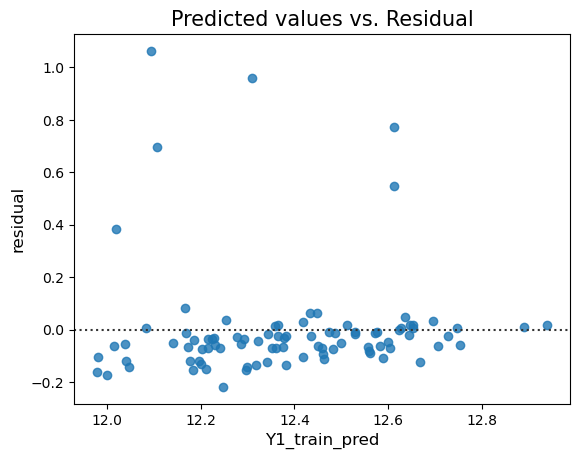

In [113]:
sns.residplot(x=Y1_train_pred, y=residual_1)
plt.xlabel("Y1_train_pred", fontsize = 12)
plt.ylabel("residual", fontsize = 12)
plt.title("Predicted values vs. Residual", fontsize=15)
plt.show()


In [114]:
# while True:
#     max_pvalue = model_1.pvalues.max()
    
#     if max_pvalue > 0.05:
#         feature_to_remove = model_1.pvalues.idxmax()
#         X_1 = X_1.drop(columns=[feature_to_remove])
#         model_1 = sm.OLS(Y_1, X_1).fit()
        
#     else:
#         break

In [115]:
# print(model_1.summary())

# Model 2 : Smoker and BMI > 30 

In [116]:
X_2 = df_2.drop(columns = 'charges', axis=1)
Y_2 = df_2['charges']

X_2 = sm.add_constant(X_2)

model_2 = sm.OLS(Y_2, X_2).fit()

### Feature selection by backward elimination method 

In [117]:
while True:
    max_pvalue = model_2.pvalues.max()
    
    if max_pvalue > 0.05:
        feature_to_remove = model_2.pvalues.idxmax()
        X_2 = X_2.drop(columns=[feature_to_remove])
        model_2 = sm.OLS(Y_2, X_2).fit()
        
    else:
        break   


In [118]:
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     153.2
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           2.14e-33
Time:                        16:43:27   Log-Likelihood:                 105.26
No. Observations:                 120   AIC:                            -204.5
Df Residuals:                     117   BIC:                            -196.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0112      0.001     15.398      0.0

In [119]:
X_2.head()

,age,bmi,smokes
14,27,42.13,1
19,30,35.30,1
23,34,31.92,1
29,31,36.30,1
38,35,36.67,1


### BP test for homoscedasticity

In [120]:
_, bp_value, _, _ = sm.stats.diagnostic.het_breuschpagan(model_2.resid, X_2)
print(bp_value)

0.5947402425326341


Since p value > 0.05, Ho is not rejected, indicating evidence of homoscedaticity (ie. the variance of the residuals is constant)

## Fitting MLR on model 2 

#### Box cox transformation

In [121]:
# df2_to_transform = Y_2
# df2_transformed, lambda_2 = stats.boxcox(df2_to_transform) 
# Y_2 = df2_transformed

In [122]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_2, Y_2, test_size=0.2, random_state=5)


In [123]:
lr = LinearRegression()
lrmodel_2 = lr.fit(X2_train, Y2_train)

In [124]:
Y2_train_pred = lrmodel_2.predict(X2_train)
Y2_test_pred = lrmodel_2.predict(X2_test)

In [125]:
residual_2 = Y2_train - Y2_train_pred

In [126]:
print(lrmodel_2.coef_)

[0.01134747 0.0176176  0.        ]


In [127]:
print(lrmodel_2.intercept_)

12.44958478472159


In [128]:
r2 = r2_score(Y2_train, Y2_train_pred)
adjr2 = 1-((1-r2)*131/124)

In [129]:
print("Training R^2 = ",r2)
print("Adjusted R^2 = ",adjr2)

Training R^2 =  0.7038482550679189
Adjusted R^2 =  0.6871300114023983


## Ridge regression model 

In [130]:
ridge_2 = Ridge()
ridge_2.fit(X2_train, Y2_train)
ridge_Y2_train_pred = ridge_2.predict(X2_train)
#ridge_r2_train = metrics.r2_score(Y_train, ridge_training_data_prediction)
print('ridge R^2 (train data) :', r2_score(Y2_train, ridge_Y2_train_pred))

ridge_Y2_test_pred = ridge_2.predict(X2_test)
#ridge_r2_test = metrics.r2_score(Y_test, ridge_testing_data_prediction)
print('ridge R^2 (test data) :', r2_score(Y2_test, ridge_Y2_test_pred))

ridge R^2 (train data) : 0.7038482048776075
ridge R^2 (test data) : 0.8985403180497327


### VIF test for multicollinearity 

In [131]:
# VIF test for multicollinearity
p = X2_train.shape[1]
print(p)

vif = [variance_inflation_factor(X2_train.values, i) for i in range(p)]
vif = pd.Series(vif, index = X2_train.columns)
print(vif)

3
age        1.003478
bmi        1.003478
smokes    84.135168
dtype: float64


VIF of all the regressor variables of the model are less than 5 indicating no multiollinearity.

### Durbin Watson test for auto-correlation 

In [132]:
durbin_watson_statistic = sm.stats.durbin_watson(residual_2)
print(durbin_watson_statistic)

2.161731415775951


Since 1.5 < Durbin-Watson statistic value < 2.5, it indicates that there is no significant autocorrelation in the residuals.

### Checking normality of residuals 

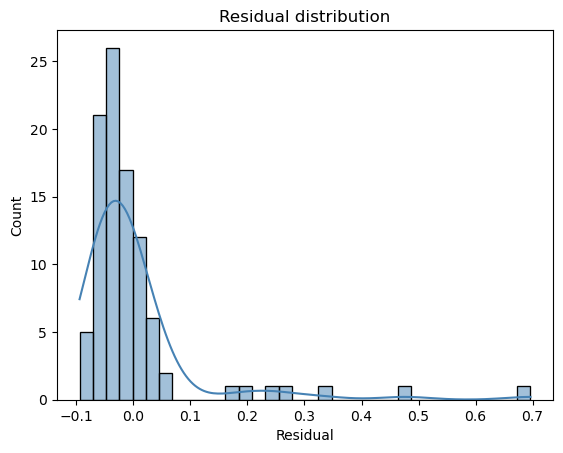

In [133]:
sns.histplot(residual_2, kde=True, color="steelblue")
plt.xlabel("Residual")
plt.title("Residual distribution")
plt.show()

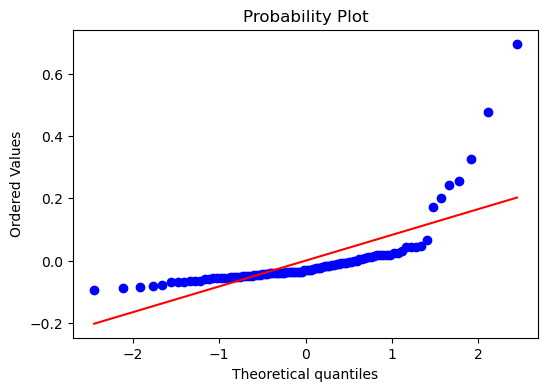

In [134]:
# QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual_2, plot=ax, fit=True)
plt.show()

In [135]:
# Shapiro-Wilk test for normality of residuals
statistic_2, p_value_2 = sp.stats.shapiro(residual_2)
print(statistic_2, p_value_2)

0.5488147735595703 1.0770371207846803e-15


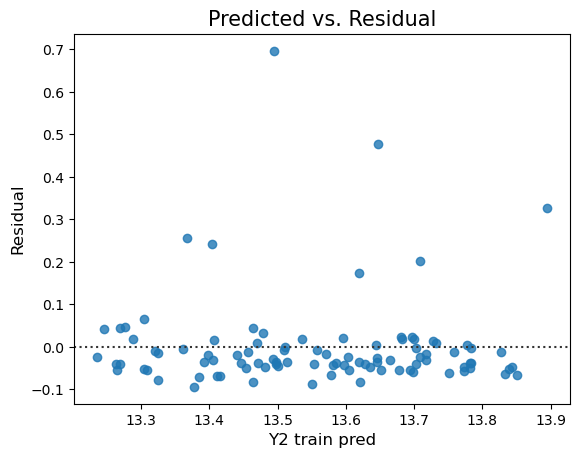

In [136]:
sns.residplot(x=Y2_train_pred, y=residual_2)
plt.xlabel("Y2 train pred", fontsize = 12)
plt.ylabel("Residual", fontsize = 12)
plt.title("Predicted vs. Residual", fontsize=15)
plt.show()

Points are mostly spread within a horizontal band in the above residual plot indicating presence of homoscedasticity (variance of residuals is constant)

### Feature selection by backward elimination method

In [137]:
# while True:
#     max_pvalue = model_2.pvalues.max()
    
#     if max_pvalue > 0.05:
#         feature_to_remove = model_2.pvalues.idxmax()
#         X_2 = X_2.drop(columns=[feature_to_remove])
#         model_2 = sm.OLS(Y_2, X_2).fit()
        
#     else:
#         break   
        


In [138]:
# print(model_2.summary())

#  Model 3 : Non Smokers

In [139]:
X_3 = df_3.drop(columns = 'charges', axis=1)
Y_3 = df_3['charges']

X_3 = sm.add_constant(X_3)

model_3 = sm.OLS(Y_3, X_3).fit()

In [140]:
while True:
    max_pvalue = model_3.pvalues.max()
    
    if max_pvalue > 0.05:
        feature_to_remove = model_3.pvalues.idxmax()
        X_3 = X_3.drop(columns=[feature_to_remove])
        model_3 = sm.OLS(Y_3, X_3).fit()
        
    else:
        break   
        


In [141]:

print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     2212.
Date:                Fri, 20 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:43:29   Log-Likelihood:                -90.963
No. Observations:                 996   AIC:                             195.9
Df Residuals:                     989   BIC:                             230.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9781      0.032    252.962      0.0

In [142]:
X_3.head()

,const,age,children,male,smokes,northwest,southeast,southwest
1,1.0,18,1,1,0,0,1,0
2,1.0,28,3,1,0,0,1,0
4,1.0,32,0,1,0,1,0,0
5,1.0,31,0,0,0,0,1,0
6,1.0,46,1,0,0,0,1,0


### BP test for homoscedasticity

In [143]:
_, bp_value, _, _ = sm.stats.diagnostic.het_breuschpagan(model_3.resid, X_3)
print(bp_value)

0.09977386830352768


In [144]:
# Attempted Box-Cox, logarithmic and square root transformation. Logarithmic Transformation gave results closest to normality 

# df3_to_transform = Y_3
# df3_transformed, lambda_3 = stats.boxcox(df3_to_transform) 
# Y_3 = df3_transformed

### Applying logarithmic Transformation 

In [145]:
# Y_3 = np.log(Y_3)

In [146]:
# Y_3 = np.sqrt(Y_3)

In [147]:
Y_3 = (Y_3)

In [148]:
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X_3, Y_3, test_size=0.2, random_state=5)


In [149]:
lr = LinearRegression()
lrmodel_3 = lr.fit(X3_train, Y3_train)

In [150]:
Y3_train_pred = lrmodel_3.predict(X3_train)
Y3_test_pred = lrmodel_3.predict(X3_test)

In [151]:
residual_3 = Y3_train - Y3_train_pred

In [152]:
print(lrmodel_3.coef_)

[ 0.00000000e+00  6.63744142e-02  1.83749329e-01 -1.39956433e-01
  5.55111512e-17 -1.30572578e-01 -2.22496283e-01 -2.38151497e-01]


In [153]:
print(lrmodel_3.intercept_)

7.9982686881282845


In [154]:
r2 = r2_score(Y3_train, Y3_train_pred)
adjr2 = 1-((1-r2)*108/106)

In [155]:
print("Training R^2 = ",r2)
print("Adjusted R^2 = ",adjr2)

Training R^2 =  0.9264341795758804
Adjusted R^2 =  0.9250461452282555


In [156]:
ridge_3 = Ridge()
ridge_3.fit(X3_train, Y3_train)
ridge_Y3_train_pred = ridge_3.predict(X3_train)
#ridge_r2_train = metrics.r2_score(Y_train, ridge_training_data_prediction)
print('ridge R^2 (train data) :', r2_score(Y3_train, ridge_Y3_train_pred))

ridge_Y3_test_pred = ridge_3.predict(X3_test)
#ridge_r2_test = metrics.r2_score(Y_test, ridge_testing_data_prediction)
print('ridge R^2 (test data) :', r2_score(Y3_test, ridge_Y3_test_pred))

ridge R^2 (train data) : 0.9264310863436929
ridge R^2 (test data) : 0.9488717449167349


### VIF test for multicollinearity

In [157]:
# VIF test for multicollinearity
p = X3_train.shape[1]
print(p)

vif = [variance_inflation_factor(X3_train.values, i) for i in range(p)]
vif = pd.Series(vif, index = X3_train.columns)
print(vif)

8
const        14.421376
age           1.003928
children      1.002979
male          1.002852
smokes             NaN
northwest     1.570561
southeast     1.577342
southwest     1.561264
dtype: float64


C:\Users\bitha\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [158]:
durbin_watson_statistic = sm.stats.durbin_watson(residual_3)
print(durbin_watson_statistic)

2.043490517784374


Since the Durbin-Watson statistic value is around 2, it indicates that there is no significant autocorrelation in the residuals.

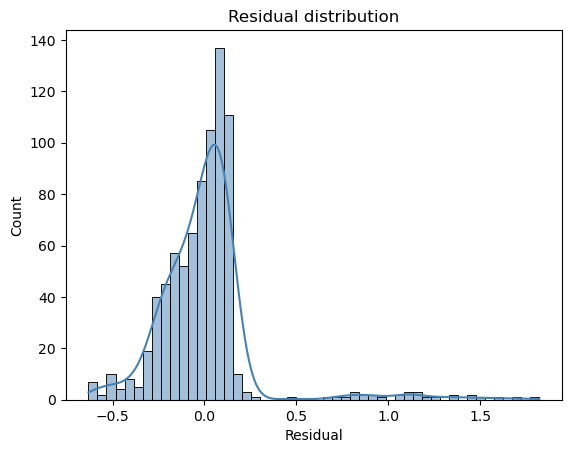

In [159]:
sns.histplot(residual_3, kde=True, color="steelblue")
plt.xlabel("Residual")
plt.title("Residual distribution")
plt.show()

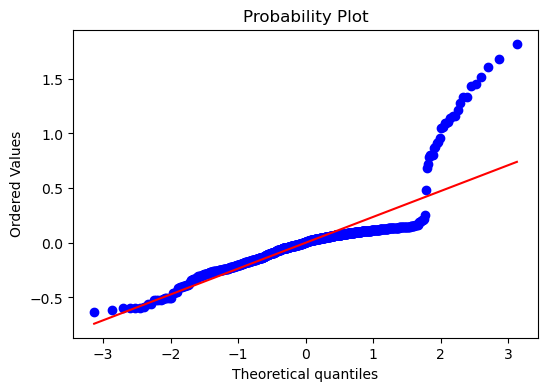

In [160]:
# QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual_3, plot=ax, fit=True)
plt.show()

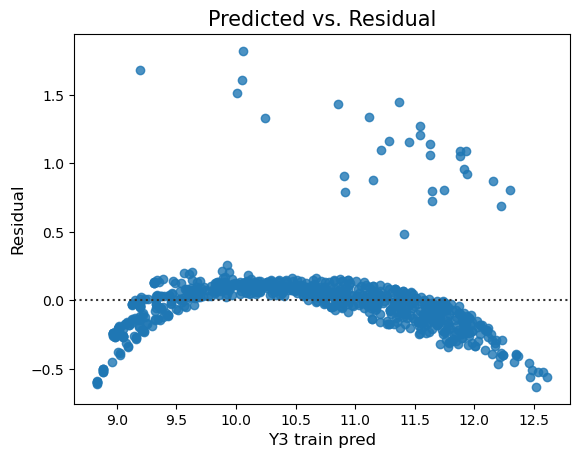

In [161]:
sns.residplot(x=Y3_train_pred, y=residual_3)
plt.xlabel("Y3 train pred", fontsize = 12)
plt.ylabel("Residual", fontsize = 12)
plt.title("Predicted vs. Residual", fontsize=15)
plt.show()

Points are mostly spread within a horizontal band in the above residual plot indicating presence of homoscedasticity (variance of residuals is constant)

In [162]:
# while True:
#     max_pvalue = model_3.pvalues.max()
    
#     if max_pvalue > 0.05:
#         feature_to_remove = model_3.pvalues.idxmax()
#         X_3 = X_3.drop(columns=[feature_to_remove])
#         model_3 = sm.OLS(Y_3, X_3).fit()
        
#     else:
#         break   
        

In [163]:
# print(model_3.summary())

In [164]:
import os
c = os.getcwd()
c

'C:\\Users\\bitha'